In [ ]:
#import the necessary libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,os.path
import seaborn as sns
import shutil

from PIL import ImageFont, Image
from tensorflow.keras import Model
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D, Reshape, BatchNormalization,Sequential,GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from keras import applications

In [ ]:
df = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

In [3]:
train_df = pd.read_csv('/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/test.csv')

In [4]:
dataset = [train_df,test_df]

In [5]:
for data in dataset:
  data['image_id'] = [filename + '.jpg' for filename in data['image_id']]

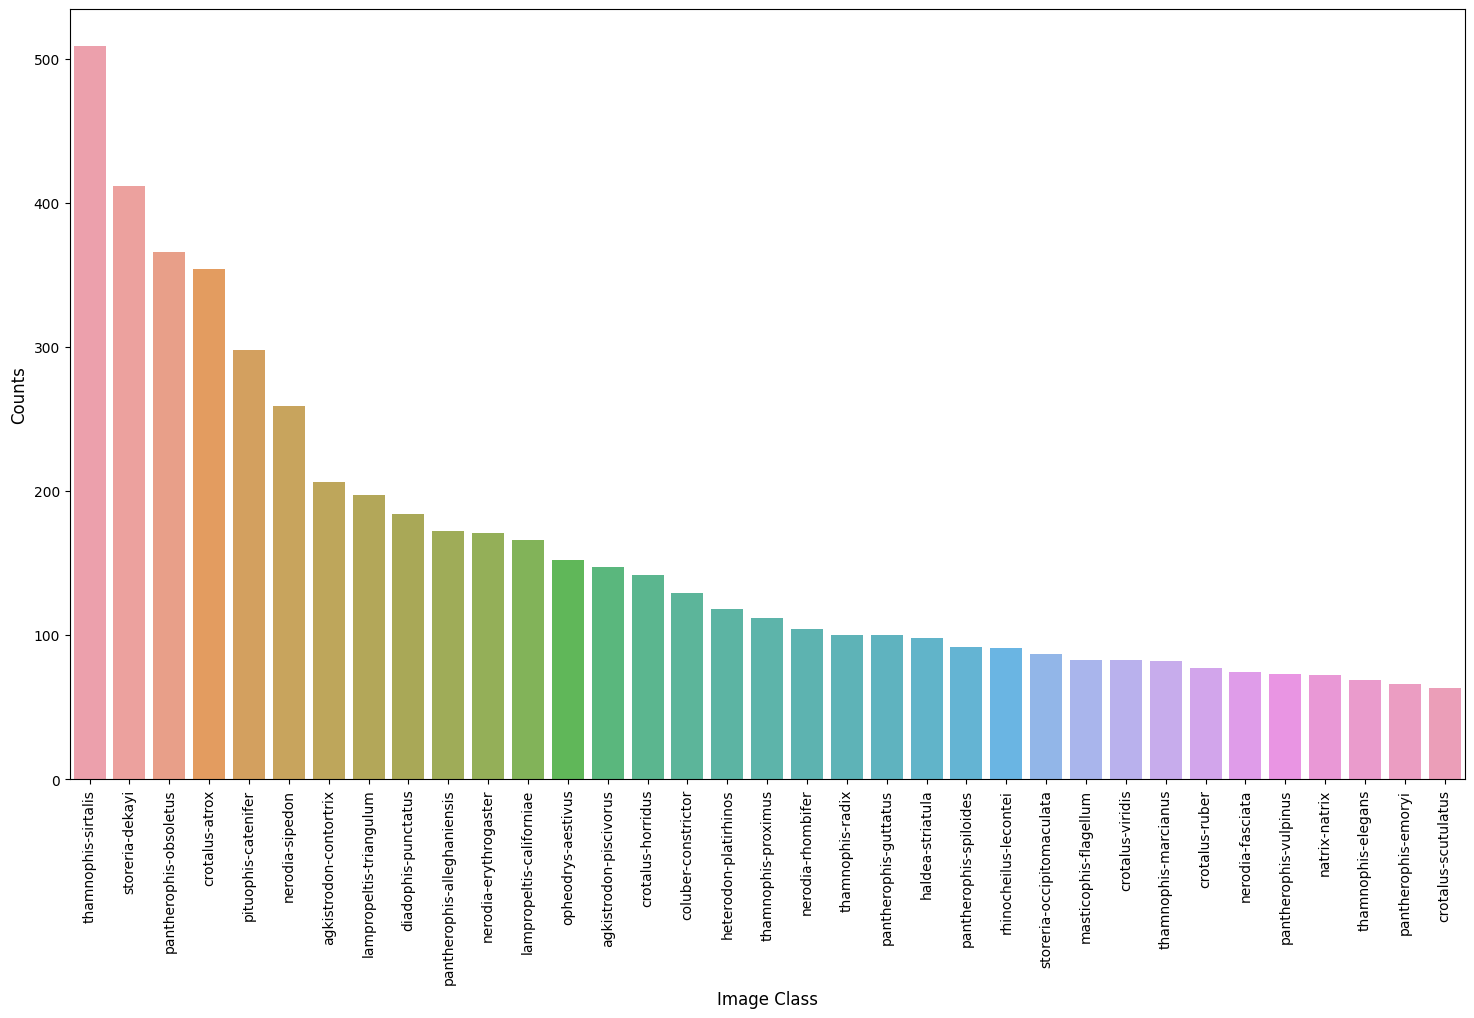

In [58]:
#plotting a bar plott for values of different species
label_counts = train_df.breed.value_counts()
plt.figure(figsize = (18,10))
sns.barplot(x=label_counts.index,y=label_counts.values,alpha=0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Class', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

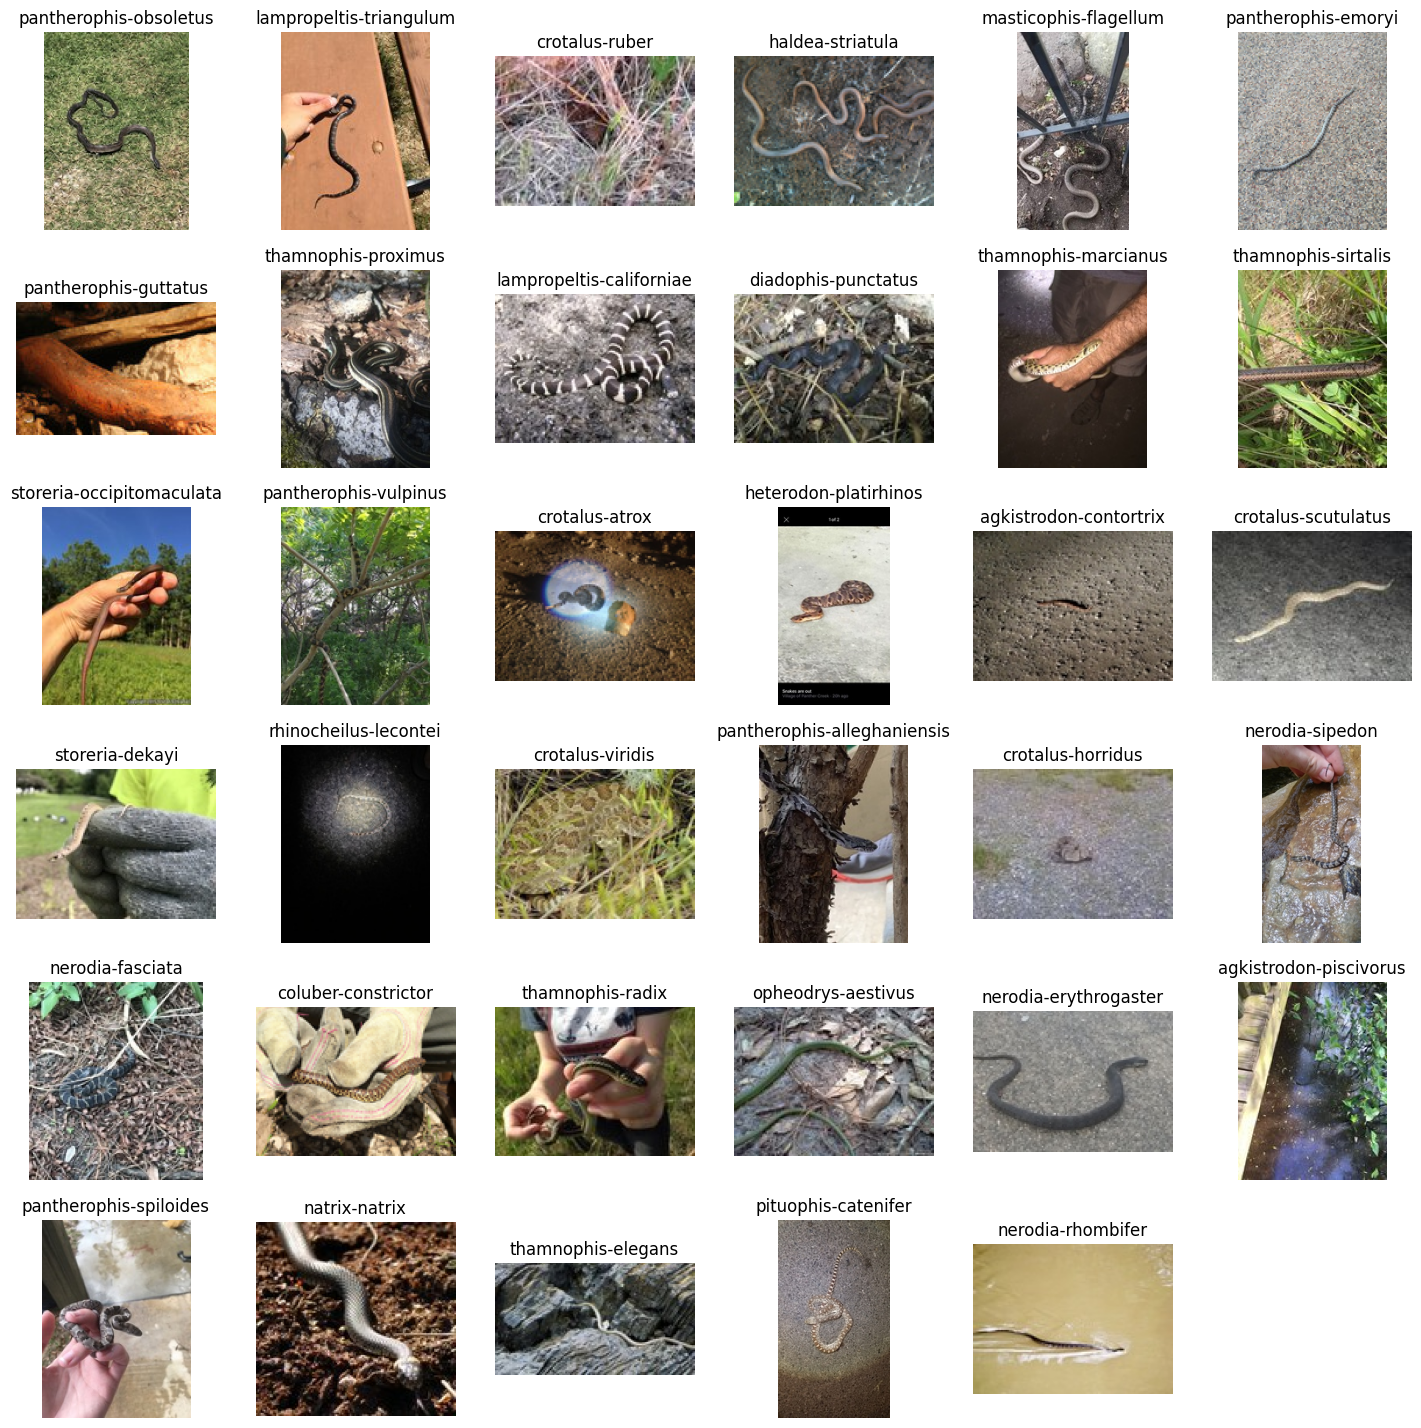

In [55]:
#for using in kaggle
#visualization of snake images
d = '/kaggle/working/dataset_imagenet_format/'
plt.figure(figsize=(18, 18))
k=0
for i in os.listdir(d):
    image = os.listdir(d+i)[0]
    Image.open(d+i+'/'+image)
    ax=plt.subplot(6,6,k+1)
    k=k+1
    plt.title(i)
    plt.axis("off")
    plt.imshow(Image.open(d+i+'/'+image))

In [6]:
# Producing Class Counts alphabetically
class_counts = train_df['breed'].value_counts()
class_counts = pd.DataFrame({'breed': class_counts.index, 'count': class_counts.values})
class_counts.sort_values(['breed'], inplace = True)
class_counts.reset_index(drop=True)

classes = class_counts['breed'].values.tolist()
print(classes)

['agkistrodon-contortrix', 'agkistrodon-piscivorus', 'coluber-constrictor', 'crotalus-atrox', 'crotalus-horridus', 'crotalus-ruber', 'crotalus-scutulatus', 'crotalus-viridis', 'diadophis-punctatus', 'haldea-striatula', 'heterodon-platirhinos', 'lampropeltis-californiae', 'lampropeltis-triangulum', 'masticophis-flagellum', 'natrix-natrix', 'nerodia-erythrogaster', 'nerodia-fasciata', 'nerodia-rhombifer', 'nerodia-sipedon', 'opheodrys-aestivus', 'pantherophis-alleghaniensis', 'pantherophis-emoryi', 'pantherophis-guttatus', 'pantherophis-obsoletus', 'pantherophis-spiloides', 'pantherophis-vulpinus', 'pituophis-catenifer', 'rhinocheilus-lecontei', 'storeria-dekayi', 'storeria-occipitomaculata', 'thamnophis-elegans', 'thamnophis-marcianus', 'thamnophis-proximus', 'thamnophis-radix', 'thamnophis-sirtalis']


In [8]:
# Creating new train data directory
os.mkdir('dataset_imagenet_format/')

# Creating one folder for each of the image classes.
for cls in classes:
    os.mkdir('/kaggle/working/dataset_imagenet_format' + '/' + cls)

In [9]:
#setting up paths
train_dir = '/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/train'
new_train_dir = '/kaggle/working/dataset_imagenet_format'

In [10]:
# Copying the Train image files to their respective class folders in the training directory.
for index , row in train_df.iterrows():
    img_path = train_dir + '/' + row['image_id']
    dst_path = new_train_dir + '/' + row['breed'] + '/' + row['image_id']
    shutil.copy(img_path, dst_path)

In [11]:
train_data = df.flow_from_dataframe(train_df,
                                                directory='/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/train',
                                                x_col = 'image_id',
                                                y_col = 'breed',
                                                target_size = (224,224),
                                                batch_size = 32,
                                                seed = 42,
                                                shuffle = True,
                                                class_mode = 'sparse',
                                                subset = 'training')

Found 4407 validated image filenames belonging to 35 classes.


In [99]:
valid_data = df.flow_from_dataframe(train_df,
                                                directory='/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/train',
                                                x_col = 'image_id',
                                                y_col = 'breed',
                                                target_size = (224,224),
                                                batch_size = 32,
                                                seed = 42,
                                                shuffle = True,
                                                class_mode = 'sparse',
                                                subset = 'validation')

Found 1101 validated image filenames belonging to 35 classes.


In [100]:
#data pipeline
def build_data_pipeline(image_dir, train_df, test_df, augment_args=None):
    if augment_args:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, **augment_args)
    else:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    test_datagen = ImageDataGenerator(rescale=1./255) # unaffected by data augmentation

    #training data
    train_batches = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=X_COL,
        y_col=Y_COL,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        classes=CLASSES,
        subset='training',
        shuffle=True,
        seed=SEED
    )
    #validation data
    val_batches = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=X_COL,
        y_col=Y_COL,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        classes=CLASSES,
        subset='validation',
        shuffle=True,
        seed=SEED
    )
    #test data
    test_batches = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/test',
        x_col=X_COL,
        target_size=TARGET_SIZE,
        batch_size=1,   # prediction done one sample at a time
        class_mode=None,    # no class associated with test sample
        shuffle=False
    )
    return train_batches, val_batches, test_batches

In [101]:
CLASSES = list(train_df.breed.unique())
X_COL = train_df.columns[0]
Y_COL = train_df.columns[-1]
CLASS_MODE = 'categorical'
SEED = 40
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
INPUT_SHAPE = TARGET_SIZE + (3, ) #3 channels for RGB

In [102]:
augment_args = {
    'rotation_range': 20, #degrees
    'shear_range': 0.1,
    'zoom_range': 0.2,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'horizontal_flip': True
}

image_dir = '/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/train'

train_batches, val_batches, test_batches = build_data_pipeline(
    image_dir, train_df, test_df, augment_args
)

Found 4407 validated image filenames belonging to 35 classes.
Found 1101 validated image filenames belonging to 35 classes.
Found 2361 validated image filenames.


In [103]:
#model graphs
def plot_training_curve(history):
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    ax[0].plot(epochs, train_loss, label='train_loss')
    ax[0].plot(epochs, val_loss, label='val_loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].minorticks_on()
    ax[0].legend()
    ax[1].plot(epochs, train_accuracy, label='train_accuracy')
    ax[1].plot(epochs, val_accuracy, label='val_accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].minorticks_on()
    ax[1].legend()
    plt.show()

In [104]:
#model fitting
def fit_model(model, train_batches, val_batches, epochs=10):
#     verbose = 2 if epochs <= 10 else 0
    verbose = 1
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=2e-4,
        patience=20,
        verbose=0,
        mode='max',
        restore_best_weights=True
    )
    history = model.fit(
        x=train_batches,
        epochs=epochs,
        callbacks=[es,rlr],
        verbose=verbose,
        steps_per_epoch=len(train_batches),
        validation_data=val_batches,
        validation_steps=len(val_batches)
    )
    print(f"Stopped training after {len(history.history['loss'])} epochs\n")
    plot_training_curve(history)

    return model, history

In [105]:
#model evaluation
def evaluate_model(model, val_batches, test_batches):
    val_score = model.evaluate(val_batches, verbose=0)
    print(f'---VALIDATION---\nloss = {val_score[0]:.4f}, accuracy = {val_score[1]*100:.2f}%')

    test_proba = model.predict(test_batches, verbose=0)
    test_preds = test_proba.argmax(axis=-1)
    test_preds_classes = [CLASSES[pred] for pred in test_preds]

    print('\n---TEST---')

### ResNet

In [106]:
base_2 = applications.resnet_v2.ResNet50V2(
    weights='imagenet', input_shape=INPUT_SHAPE, include_top=False
)

In [108]:
def build_model(base_model):
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.45),
        Dense(35, activation="softmax")
    ])
    model.compile(
        loss="categorical_crossentropy",
        optimizer='Adam',
        metrics=["accuracy"]
    )
    return model

In [109]:
model_2 = build_model(base_2)

In [110]:
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_26 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_17 (Dropout)        (None, 1024)              0         
                                                                 
 dense_27 (Dense)            (None, 35)                35875     
                                                                 
Total params: 25698851 (98.03 MB)
Trainable params: 2134051 (8.14 MB)
Non-trainable params: 23564800 (89.89 MB)
________

Epoch 1/40
138/138 [==============================] - 64s 467ms/step - loss: 2.9877 - accuracy: 0.2008 - val_loss: 2.8120 - val_accuracy: 0.2271 - lr: 0.0010
Epoch 2/40
138/138 [==============================] - 63s 457ms/step - loss: 2.7480 - accuracy: 0.2423 - val_loss: 2.7314 - val_accuracy: 0.2543 - lr: 0.0010
Epoch 3/40
138/138 [==============================] - 64s 465ms/step - loss: 2.5945 - accuracy: 0.2746 - val_loss: 2.6725 - val_accuracy: 0.2725 - lr: 0.0010
Epoch 4/40
138/138 [==============================] - 63s 457ms/step - loss: 2.4768 - accuracy: 0.3011 - val_loss: 2.6735 - val_accuracy: 0.2598 - lr: 0.0010
Epoch 5/40
138/138 [==============================] - 63s 454ms/step - loss: 2.3631 - accuracy: 0.3254 - val_loss: 2.7069 - val_accuracy: 0.2670 - lr: 0.0010
Epoch 6/40
138/138 [==============================] - 64s 463ms/step - loss: 2.2804 - accuracy: 0.3440 - val_loss: 2.6835 - val_accuracy: 0.2598 - lr: 0.0010
Epoch 7/40
138/138 [==============================] 

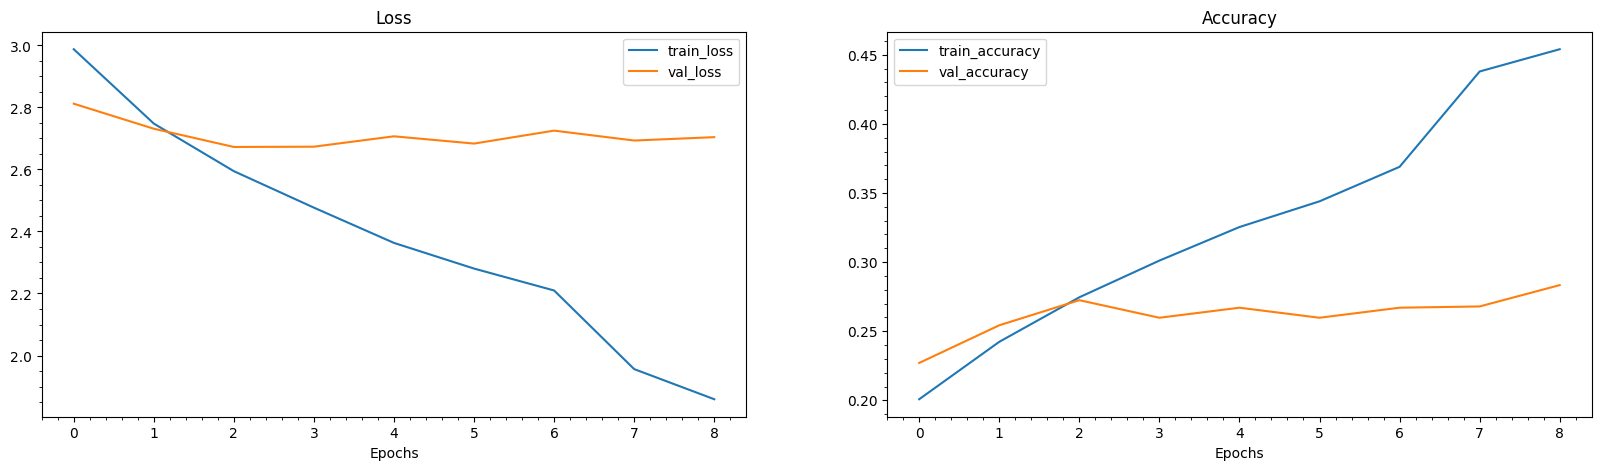

In [112]:
model_2, history_2 = fit_model(model_2, train_batches, val_batches, epochs=40)

In [114]:
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 1,
                                min_delta = 1e-4, min_lr = 1e-4, mode = 'min', cooldown=1)
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 6,mode = 'min', restore_best_weights = True, verbose = 1)


### VGG16

In [115]:
base_3 = applications.VGG16(
    weights='imagenet', input_shape=INPUT_SHAPE, include_top=False
)

In [116]:
model_3 = build_model(base_3)

Epoch 1/20
138/138 [==============================] - 65s 461ms/step - loss: 3.3902 - accuracy: 0.1037 - val_loss: 3.2741 - val_accuracy: 0.1290 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 64s 464ms/step - loss: 3.2576 - accuracy: 0.1312 - val_loss: 3.2254 - val_accuracy: 0.1453 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 66s 476ms/step - loss: 3.2032 - accuracy: 0.1405 - val_loss: 3.1830 - val_accuracy: 0.1544 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 65s 470ms/step - loss: 3.1654 - accuracy: 0.1477 - val_loss: 3.1629 - val_accuracy: 0.1580 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 64s 461ms/step - loss: 3.1236 - accuracy: 0.1532 - val_loss: 3.1206 - val_accuracy: 0.1571 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 64s 465ms/step - loss: 3.0839 - accuracy: 0.1641 - val_loss: 3.0951 - val_accuracy: 0.1571 - lr: 0.0010
Epoch 7/20
138/138 [==============================] 

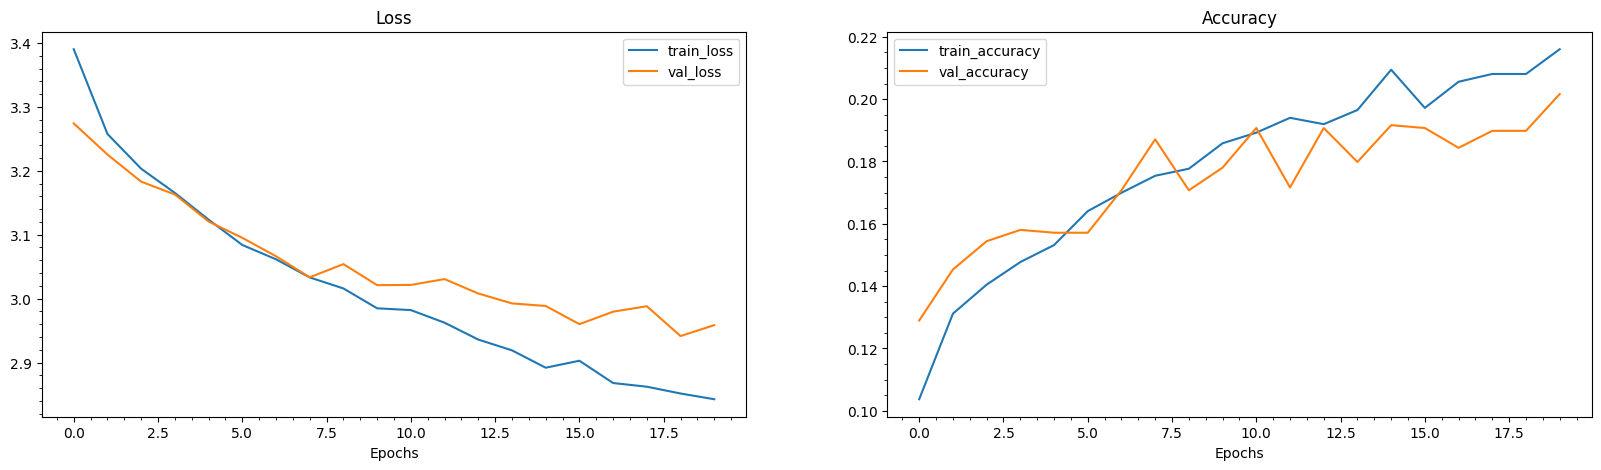

In [117]:
model_3, history_3 = fit_model(model_3, train_batches, val_batches, epochs=20)

### DenseNet

In [118]:
base_4 = applications.DenseNet201(
    weights='imagenet', input_shape=INPUT_SHAPE, include_top=False
)

In [121]:
model_4 = build_model(base_4)

Epoch 1/20
138/138 [==============================] - 81s 506ms/step - loss: 3.2672 - accuracy: 0.1493 - val_loss: 2.9146 - val_accuracy: 0.2234 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 66s 479ms/step - loss: 2.8387 - accuracy: 0.2274 - val_loss: 2.7250 - val_accuracy: 0.2516 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 65s 468ms/step - loss: 2.6695 - accuracy: 0.2634 - val_loss: 2.7034 - val_accuracy: 0.2589 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 66s 478ms/step - loss: 2.5510 - accuracy: 0.2914 - val_loss: 2.6217 - val_accuracy: 0.2743 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 66s 478ms/step - loss: 2.4721 - accuracy: 0.3081 - val_loss: 2.5443 - val_accuracy: 0.3025 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 68s 494ms/step - loss: 2.3988 - accuracy: 0.3140 - val_loss: 2.5189 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 7/20
138/138 [==============================] 

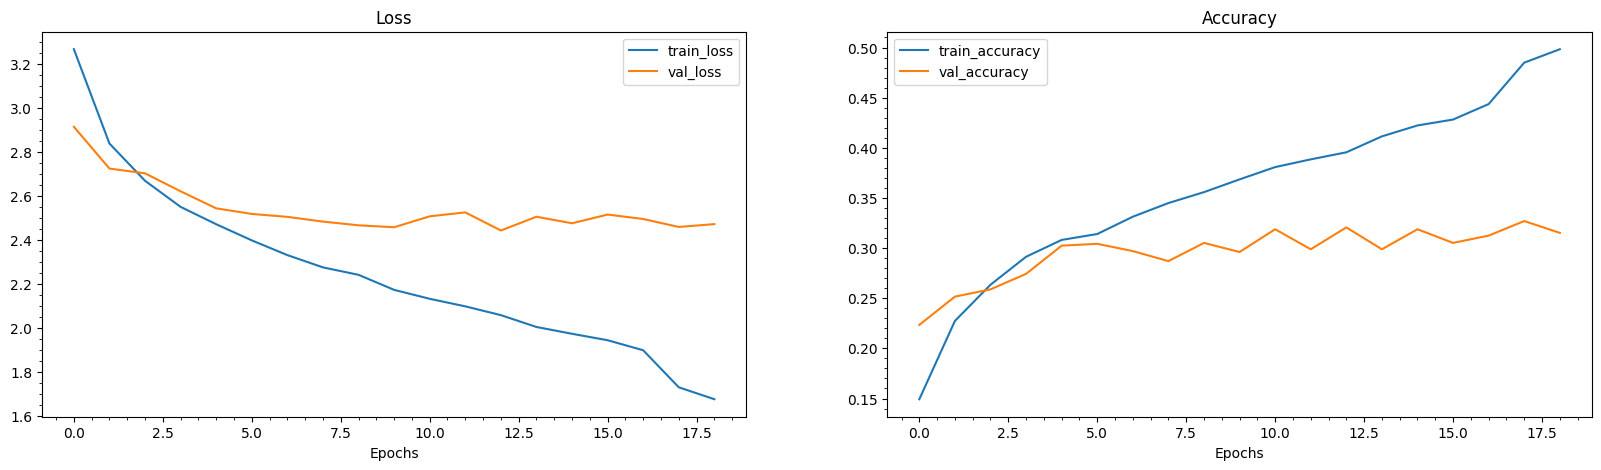

In [122]:
model_4, history_4 = fit_model(model_4, train_batches, val_batches, epochs=20)